# **YOLO Instance Segmentation**
***

In [1]:
from ultralytics import YOLO
import torch
import time
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt

***
**Datenset im YOLO Format generieren**

In [2]:
validation_set_size = 0.2
test_set_size = 0.1

In [3]:
labelme_json_path = "C:/Users/morit/Desktop/YoloV8_InstanceSeg/dataset"
yolo_dataset_path = "C:/Users/morit/Desktop/YoloV8_InstanceSeg/dataset/YOLOv8Dataset"

In [4]:
if os.path.exists(yolo_dataset_path):
    print("Dataset already existing...")
    print("Generate new dataset?")
else:
    print("Generating YOLOv8 Dataset...")
    !python -m labelme2yolov8 --json_dir {labelme_json_path} --val_size {validation_set_size} --test_size {test_set_size}
    print("Done!")

Dataset already existing...
Generate new dataset?


In [5]:
generate_new_dataset = False

if generate_new_dataset:
    print("Deleting old dataset...")
    shutil.rmtree(yolo_dataset_path)
    print("Generate new dataset...")
    !pip install labelme2yolov8
    !python -m labelme2yolov8 --json_dir {labelme_json_path} --val_size {validation_set_size} --test_size {test_set_size}
    print("Done!")
else:
    print("Using existing dataset!")

Using existing dataset!


***
**Modell laden**

In [33]:
use_new_model = False
selected_model = "nano"         # nano -> small -> medium -> large -> xlarge

if use_new_model:
    print("Load new model...")
    if selected_model == "nano":
        model = YOLO("yolo11n-seg.pt")
    elif selected_model == "small":
        model = YOLO("yolov8s-seg.pt")
    elif selected_model == "medium":
        model = YOLO("yolov8m-seg.pt")
    elif selected_model == "large":
        model = YOLO("yolov8l-seg.pt")
    elif selected_model == "xlarge":
        model = YOLO("yolov8x-seg.pt")

else:
    print("Load saved model...")
    if selected_model == "nano":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\20250110_2023_yolo8nano_pruned.pt")
    elif selected_model == "small":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\20250111_1258_best_small.pt")
    elif selected_model == "medium":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\best_medium.pt")
    elif selected_model == "large":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\best_large.pt")
    elif selected_model == "xlarge":
        model = YOLO(r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\models\best_xlarge.pt")

print("Model loaded successfully!") if model is not None else print("Model load failed!")

Load saved model...
Model loaded successfully!


In [34]:
use_gpu = False

if use_gpu and torch.cuda.is_available():
    device = "cuda"
    print("Using GPU!\n\n")
    !nvidia-smi
else:
    device = "cpu"
    print("Using CPU!")

Using CPU!


***
**Training**

In [35]:
train_mode = False

In [36]:
yaml_path = r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\dataset\YOLOv8Dataset\dataset.yaml"         # Dataset Config YAML file

In [37]:
num_epochs = 1000

learning_rate = 1e-4
optimizer = "Adam"      # SGD, Adam, AdamW, NAdam, RAdam, RMSProp
dropout_rate = 0.0
use_validation = True
save_plots = True

max_train_time_in_hours = None          # max Trainingszeit in h -> wenn None, dann volle Epochen
batch_size = -1                         # -1 setzt Batches automatisch, sodass GPU-Speicher 60% genutzt
save_every_x_epochs = -1                # Automatische Speicherung alle x Epoche -> wenn -1, dann deaktiviert
change_picture_scale = True             # veraendert die Bildgroesse waehrend Training
merge_seg_masks = False                 # Masken zusammenführen -> für Instance Segmentation ungeeignet

In [38]:
if train_mode:
    train_results = model.train(
        data=yaml_path,
        epochs=num_epochs,
        lr0=learning_rate,
        optimizer=optimizer,
        dropout=dropout_rate,
        val = use_validation,
        plots = save_plots,
        time = max_train_time_in_hours,
        batch = batch_size,
        save_period = save_every_x_epochs,
        multi_scale = change_picture_scale,
        overlap_mask = merge_seg_masks,
        imgsz=640,
        device=device
    )

***
**Single Image Inference**

In [39]:
img_path = r"C:\Users\morit\Desktop\YoloV8_InstanceSeg\dataset\image_1736193089.png"
frame = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

In [51]:
confidence_threshold = 0.4
max_hooks = 100

In [52]:
start_time = time.perf_counter()

results = model.predict(source = img_path,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)

end_time = time.perf_counter()

print(f"\nInferenz-Laufzeit: {end_time- start_time:.5f} sec")


image 1/1 C:\Users\morit\Desktop\YoloV8_InstanceSeg\dataset\image_1736193089.png: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 51.4ms
Speed: 1.7ms preprocess, 51.4ms inference, 45.1ms postprocess per image at shape (1, 3, 352, 640)

Inferenz-Laufzeit: 0.11349 sec


In [53]:
def annotate_frame(frame, results):
    annotated_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    class_colors = {
        0: (255, 0, 0),         # bar -> rot
        1: (0, 255, 0),         # hook -> gruen
        2: (0, 0, 255),         # tip -> blau
        3: (255, 255, 0),       # lowpoint -> cyan
    }

    labelnames = ["bar",
                  "hook",
                  "tip",
                  "lowpoint"]

    for result in results:
        # Bounding Boxes
        if result.boxes is not None:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Boxkoordinaten
                conf = box.conf[0]                      # Konfidenzwert
                label = int(box.cls[0])                 # Klassenindex
                color = class_colors.get(label, (255, 255, 255))

                # Zeichne Rechteck und Beschriftung
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(annotated_frame, f"{labelnames[label]} ({conf:.2f})",
                            (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Masken
        if result.masks is not None:
            for i, mask in enumerate(result.masks.data):
                mask = mask.cpu().numpy()
                mask = (mask > 0.5).astype(np.uint8)  # Binärmaske (0 und 1)

                # Skaliere Maske auf Größe des Originalbildes
                mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]))

                # Erzeuge farbige Maske
                label = int(result.boxes.cls[i])                    # Klasse der Maske
                color = class_colors.get(label, (255, 255, 255))
                colored_mask = np.zeros_like(annotated_frame)
                for c in range(3):                                  # Maske auf alle Kanäle anwenden
                    colored_mask[:, :, c] = mask_resized * color[c]

                # Füge farbige Maske zum annotierten Bild hinzu
                annotated_frame = cv2.addWeighted(annotated_frame, 1.0, colored_mask, 0.5, 0)

    return annotated_frame

In [54]:
annotated_frame = annotate_frame(frame, results)

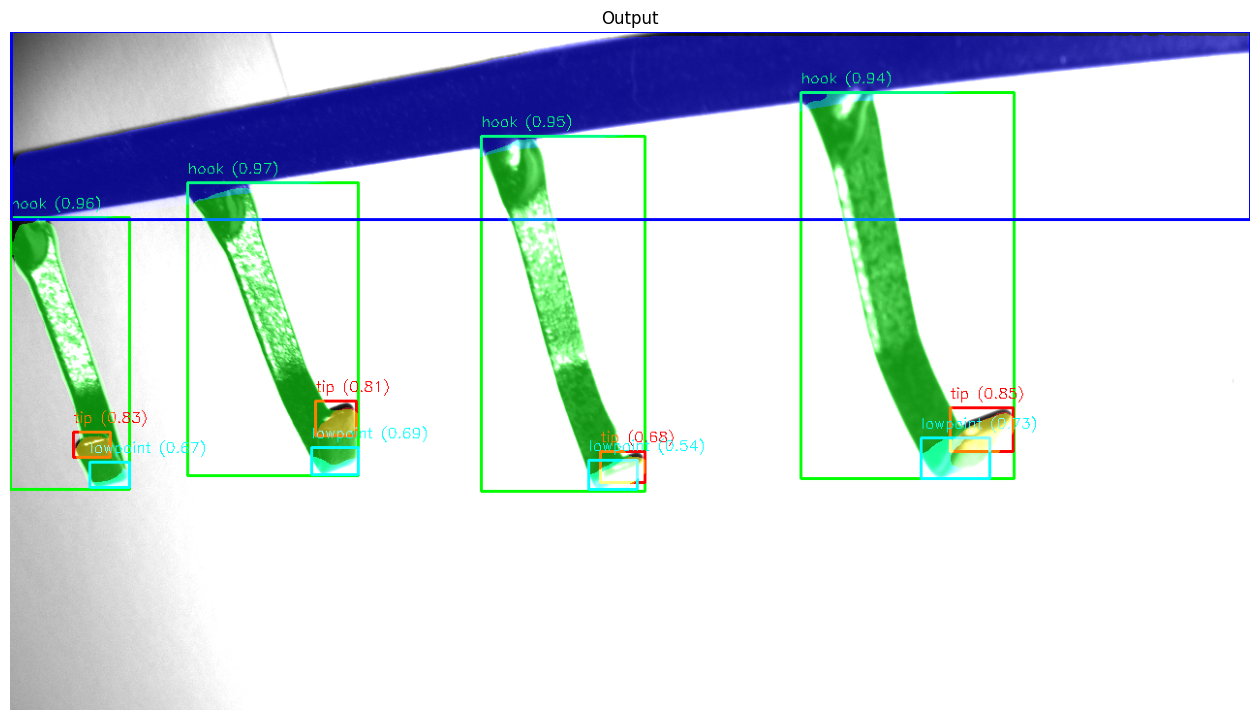

In [55]:
plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))  # Konvertiere BGR zu RGB für Matplotlib
plt.axis("off")
plt.title("Output")
plt.show()

***
**Inferenz Laufzeit-Messung**

In [45]:
num_inference_runs = 1000

time_values = []

for inf in range(num_inference_runs):
    start_time = time.perf_counter()
    results = model.predict(source = img_path,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)
    end_time = time.perf_counter()
    time_taken = end_time - start_time
    time_values.append(time_taken)


print(f"Inferenz-Laufzeiten:")
print()

for inference in range(len(time_values)):
    print(f"Inferenz {inference + 1}: {time_values[inference]:.2f} Sekunden")
    print()

print(f"Durchschnittlche Inferenzlaufzeit: {sum(time_values)/(len(time_values)):.4f} Sekunden")


image 1/1 C:\Users\morit\Desktop\YoloV8_InstanceSeg\dataset\image_1736193089.png: 352x640 1 bar, 4 hooks, 4 tips, 6 lowpoints, 50.1ms
Speed: 0.5ms preprocess, 50.1ms inference, 43.2ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 C:\Users\morit\Desktop\YoloV8_InstanceSeg\dataset\image_1736193089.png: 352x640 1 bar, 4 hooks, 4 tips, 6 lowpoints, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 42.7ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 C:\Users\morit\Desktop\YoloV8_InstanceSeg\dataset\image_1736193089.png: 352x640 1 bar, 4 hooks, 4 tips, 6 lowpoints, 41.3ms
Speed: 1.1ms preprocess, 41.3ms inference, 41.2ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 C:\Users\morit\Desktop\YoloV8_InstanceSeg\dataset\image_1736193089.png: 352x640 1 bar, 4 hooks, 4 tips, 6 lowpoints, 38.2ms
Speed: 0.0ms preprocess, 38.2ms inference, 40.8ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 C:\Users\morit\Desktop\YoloV8_InstanceSeg\dataset\image_1